# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets-200etiquetados.csv', sep = ',')

In [6]:
tweets_df.shape

(199, 2)

In [7]:
tweets_df.head()

,full_text,sentiment
0,"Cómo es posible afirmar que hay democracia en Colombia cuando estamos realizando elecciones a la presidencia en medio de la guerra contra la población? Como diría la filósofa Hannah Arendt, allí donde comienza la violencia, termina la política\r\n #ParenLaGuerra",negative
1,"Lo peor que le puede pasar a Colombia son las elecciones. Sacan lo mas feo de muchas personas, la intolerancia, el individualismo, la manipulación, etc.\r\n \r\n Voy a tener que limpiar mi twitter porque ya me cansé. \r\n \r\n No hay cuerpo que lo resista!",negative
2,"Gracias a los Acuerdos de paz de La Habana en 2018 Colombia tuvo las elecciones más pacíficas de su historia. \r\n \r\n Uribismo nos devolvió a elecciones en medio de guerra, paros armados y violaciones masivas a los ddhh.",neutral
3,"@Danielacad3 Consejo de un Venezolano que ama a Colombia. No bajen la guardia, el que cuenta los votos @Registraduria es FICHA DEL FORO DE SAO PAULO. Todavía hay vicios de las elecciones pasadas para favorecer al Pacto Histórico y ni pío a dicho el tipo. Pilas pues",negative
4,@supershadai @Registraduria Quien o que institución en Colombia atiende los reclamos al fraude electoral?\r\n Porque no suspender a al registrador que ya la defeco en las elecciones de senado y camara.\r\n Hay una desconfianza general en cuanto a las presidenciales.\r\n Están provocando una respuesta violenta.,neutral


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.502513
neutral     0.422111
positive    0.075377
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [9]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [10]:
tweets_labeled_df.shape

(199, 2)

In [11]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [12]:
tweets_unlabeled_df.shape

(0, 2)

In [13]:
# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

### Splitting train and test datasets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.1 , stratify = tweets_labeled_df['sentiment'], random_state = 1)

In [15]:
X_train.shape

(179,)

In [16]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.502793
positive    0.497207
Name: sentiment, dtype: float64

In [17]:
X_test.shape

(20,)

In [18]:
pd.Series(y_test).value_counts(normalize = True)

positive    0.5
negative    0.5
Name: sentiment, dtype: float64

### Vectorizing texts

In [19]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [20]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
X_bow = bow.fit_transform(X_train)

In [22]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [23]:
model = RandomForestClassifier()

In [24]:
model.fit(X_bow, y_train)

RandomForestClassifier()

In [25]:
y_train_bow_predict = model.predict(X_bow)
y_test_bow_predict = model.predict(bow.transform(X_test))

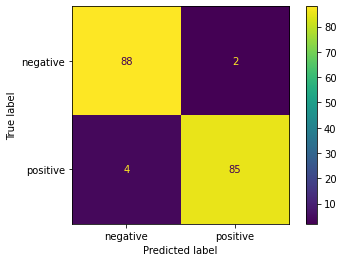

In [26]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

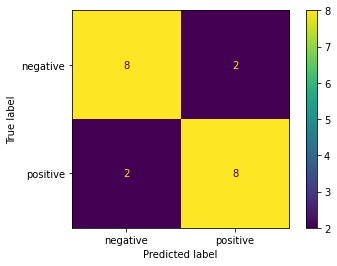

In [27]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [28]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.8 0.8]
Recall: [0.8 0.8]
F1: [0.8 0.8]


### Training and evaluating a model using TF-IDF

In [29]:
model = RandomForestClassifier()

In [30]:
model.fit(X_tfidf, y_train)

RandomForestClassifier()

In [31]:
y_train_tfidf_predict = model.predict(X_tfidf)
y_test_tfidf_predict = model.predict(bow.transform(X_test))

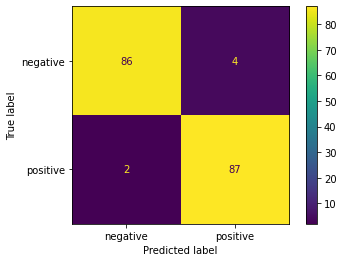

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

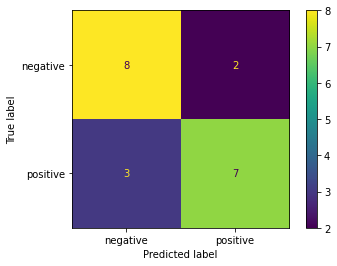

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [34]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.72727273 0.77777778]
Recall: [0.8 0.7]
F1: [0.76190476 0.73684211]


### How interpret the results?

### Analyzing errors

In [35]:
error_df1 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df1.drop('index', inplace = True, axis = 1)

In [36]:
error_df1.shape

(20, 3)

In [37]:
error_df1.loc[error_df1['actual'] != error_df1['predicted']].head(20)

,full_text,actual,predicted
1,"@DanielPalam @MinInterior @INPEC_Colombia @DanielPalam para cuando #TodaLaContundenciaContraLaCriminalidad en la @Registraduria ?\r\n Cree q las elecciones #M29 con el #registradorcorrupto Alex Vega y con las denuncias @NoticiasRCN de lo que pasó en Marzo 13, estas no se las va a robar? \r\n Contundencia esperamos con esto.",positive,negative
7,"@CARLOSFMEJIA @Asdrubal1518 @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA Deben suspender elecciones, no es correcto prestarse a un fraude",negative,positive
11,"@RICHENAO El @PactoHistorico de @petrogustavo , a @CNE_COLOMBIA @Doris_MendezC jamás los tendría en Cuenta cómo jurados o vigilantes en unas elecciones",positive,negative
15,"Senador da por sentado que se comete un flagrante fraude en algo tan crítico para el futuro de Colombia como las elecciones del Congreso y no se puede hacer nada? Solo están ustedes para hablar legislar No deben dignificar, hacer respetar el Legislativo y defender la PatriaO NO? \r\nhttps://t.co/9beqop9fPU",negative,positive


### Analyzing errors TF-IDF

In [38]:
error_df2 = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_tfidf_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df2.drop('index', inplace = True, axis = 1)

In [39]:
error_df2.shape

(20, 3)

In [40]:
error_df2.loc[error_df2['actual'] != error_df2['predicted']].head(20)

,full_text,actual,predicted
0,"@lafm tremendo informe de la posible corrupción en el fraude del pasado 13 de marzo a la Colombia humana le asignaron 24 mil jurados que si votaron 2 veces cada uno significaría el robo más grande en Colombia, y el registrador intento quitar la huella y la firma de las elecciones",positive,negative
1,"@DanielPalam @MinInterior @INPEC_Colombia @DanielPalam para cuando #TodaLaContundenciaContraLaCriminalidad en la @Registraduria ?\r\n Cree q las elecciones #M29 con el #registradorcorrupto Alex Vega y con las denuncias @NoticiasRCN de lo que pasó en Marzo 13, estas no se las va a robar? \r\n Contundencia esperamos con esto.",positive,negative
7,"@CARLOSFMEJIA @Asdrubal1518 @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA Deben suspender elecciones, no es correcto prestarse a un fraude",negative,positive
10,"Lo peor que le puede pasar a Colombia son las elecciones. Sacan lo mas feo de muchas personas, la intolerancia, el individualismo, la manipulación, etc.\r\n \r\n Voy a tener que limpiar mi twitter porque ya me cansé. \r\n \r\n No hay cuerpo que lo resista!",negative,positive
11,"@RICHENAO El @PactoHistorico de @petrogustavo , a @CNE_COLOMBIA @Doris_MendezC jamás los tendría en Cuenta cómo jurados o vigilantes en unas elecciones",positive,negative
